# 3) Analyze and evaluate optimization output

This final notebook uses the `runs.pkl` file created in notebook 2 and it analyzes:

- the distance between different feature sets in the parameter space
- the distance between different feature sets in the feature space
- the distance between different feature sets in the extracellular signals

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import sys
import shutil

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import matplotlib.pyplot as plt
from scipy.spatial import distance
import MEAutility as mu
import json
import time
import numpy as np
from pathlib import Path

import multimodalfitting as mf

%matplotlib notebook

## Load GT params and optimization output

In [2]:
# general
model_name = "hay_ais"
probe_type = "planar" # linear 
data_base_folder = Path(f"/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/multimodalfitting/data_210927")

cell_models_folder = Path("..") / "cell_models"
model_folder = cell_models_folder / f"{model_name}_model"

In [3]:
data_folder = data_base_folder / f"{model_name}_ecode_probe_{probe_type}"

# change this with folder containing your pkl file
result_folder = Path("..") / "results" / '211021' 

In [4]:
cell = mf.create_ground_truth_model(model_name=model_name, cell_model_folder=model_folder,
                                    release=False)
cell_release = mf.create_ground_truth_model(model_name=model_name, cell_model_folder=model_folder,
                                               release=True)

probe = mf.define_electrode(probe_type=probe_type)

param_names = [param.name for param in cell.params.values() if not param.frozen]
sim = ephys.simulators.LFPySimulator(cell, cvode_active=True, electrode=probe, mechs_folders=model_folder)

params_release = {}
for param in cell_release.params_by_names(param_names):
    params_release[param.name] = param.value

In [5]:
protocol_for_eap = "IDrest_300"

In [9]:
pkl_file_name = "runs.pkl"

In [10]:
data = pickle.load(open(result_folder / pkl_file_name, 'rb'))
df_optimization = pd.DataFrame(data)
df_model = df_optimization.query(f"model == '{model_name}'")

In [11]:
opt_soma = df_model.query("feature_set == 'soma'")
opt_extra = df_model.query("feature_set == 'extra'")
print(f"Somatic optimizations: {len(opt_soma)}")
print(f"Extra optimizations: {len(opt_extra)}")

Somatic optimizations: 10
Extra optimizations: 20


In [12]:
df_model.extra_strategy

0     sections
2          all
7          all
8     sections
10    sections
13         all
14         all
15         all
16         all
21    sections
23         all
26         all
27         all
28         all
29         all
34         all
36         all
37         all
38    sections
39         all
41         all
43         all
44    sections
48    sections
49         all
52         all
53    sections
55    sections
57    sections
58         all
Name: extra_strategy, dtype: object

<IPython.core.display.Javascript object>


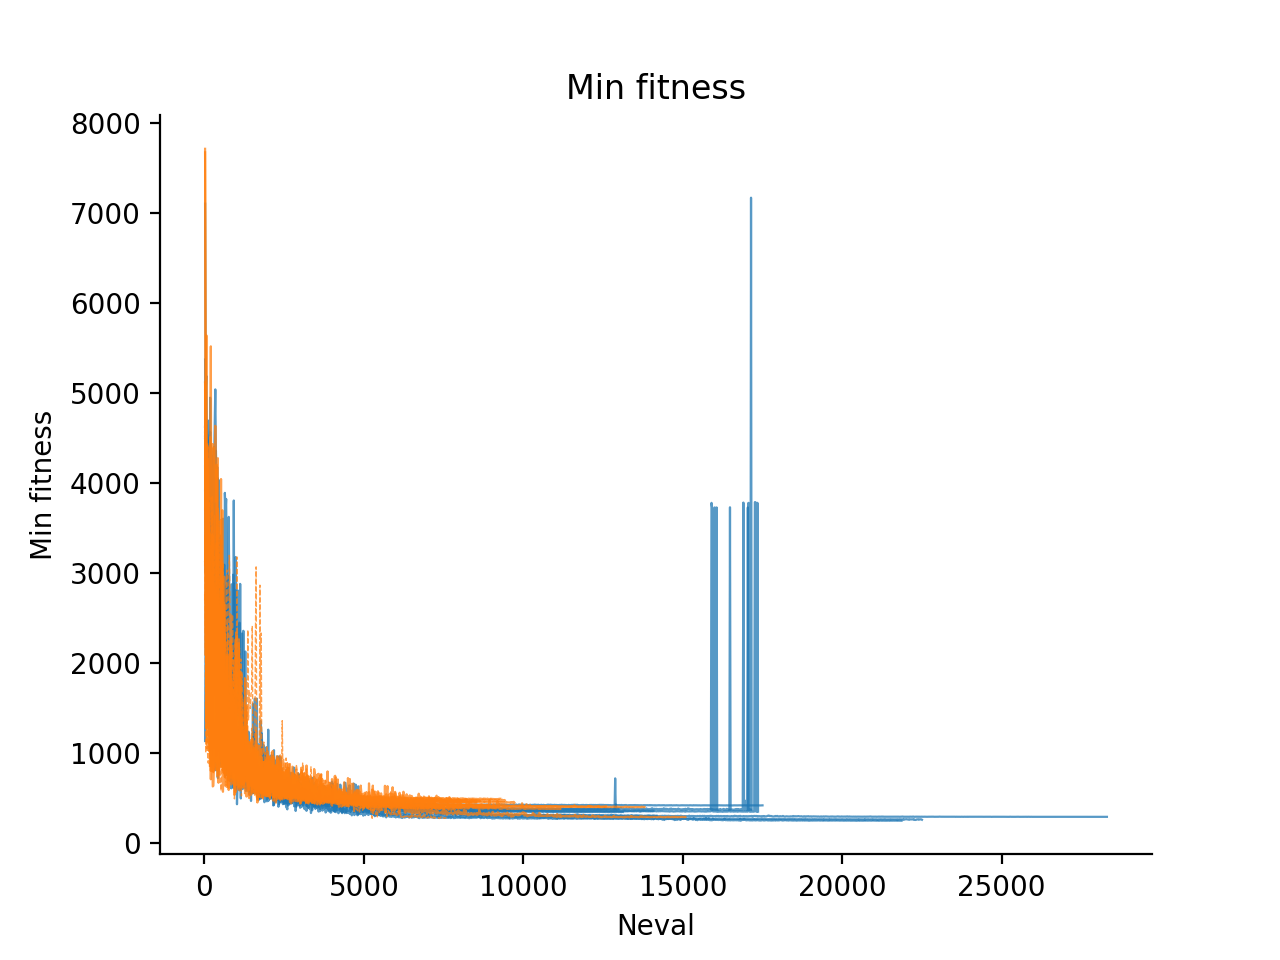

9120
8100
7580
15080
13800
9280
9720
7740
7660
7900
6620
8520
7260
7240
8640
12580
9420
8900
8520
11160


Text(0, 0.5, 'Min fitness')

In [27]:
fig, ax = plt.subplots()
min_evals = 8000

keep_idxs_soma = []
for idx, row in opt_soma.iterrows():
    if max(row["nevals"]) > min_evals:
        keep_idxs_soma.append(idx)
        ax.plot(row["nevals"], 
                row["logbook"].select("min"),
                color="C0",
                ls='-', 
                lw=0.8,
                alpha=0.75)
    else:
        ax.plot(row["nevals"], 
                row["logbook"].select("min"),
                color="C0",
                ls='--', 
                lw=0.5,
                alpha=0.75)
keep_idx_extra = []
for idx, row in opt_extra.iterrows():
    print(max(row['nevals']))
    if max(row["nevals"]) > min_evals:
        keep_idx_extra.append(idx)
        ax.plot(row["nevals"], 
                row["logbook"].select("min"),
                color="C1",
                ls='-', 
                lw=0.8,
                alpha=0.75, 
                label=idx)
    else:
        ax.plot(row["nevals"], 
                row["logbook"].select("min"),
                color="C1",
                ls='--', 
                lw=0.5,
                alpha=0.75, 
                label=idx)
ax.set_title("Min fitness")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Neval")
ax.set_ylabel("Min fitness")


# Load protocols and original features

In [19]:
protocols_file = data_folder / "efeatures" / "protocols_BPO_all.json"
feature_file = data_folder / "efeatures" / "features_BPO_all.json"

In [20]:
extra_kwargs = dict(fs=20,
                    fcut=[300, 6000],
                    filt_type="filtfilt",
                    ms_cut=[3, 10])

In [21]:
eva_soma = mf.create_evaluator(
    model_name=model_name,
    cell_model_folder=model_folder,
    feature_set="soma",
    feature_file=feature_file,
    protocol_file=protocols_file,
    **extra_kwargs
)

In [22]:
eva_extra = mf.create_evaluator(
    model_name=model_name,
    cell_model_folder=model_folder,
    feature_set="extra",
    feature_file=feature_file,
    protocol_file=protocols_file,
    probe_type=probe_type,
    protocols_with_lfp="IDrest_300",
    **extra_kwargs
)

In [23]:
len(eva_extra.fitness_calculator.objectives)

81

In [24]:
len(eva_soma.fitness_calculator.objectives)

70

In [29]:
len(keep_idx_extra)

13

In [30]:
opt_soma = opt_soma.loc[keep_idxs_soma]

In [31]:
opt_extra = opt_extra.loc[keep_idx_extra]

In [32]:
opt_extra.extra_strategy

0     None
7     None
10    None
16    None
21    None
23    None
41    None
48    None
49    None
53    None
55    None
57    None
58    None
Name: extra_strategy, dtype: object

# Compute release responses

In [33]:
params_release

{'g_pas_somatic': 2.48351379540536e-05,
 'g_pas_basal': 2.48351379540536e-05,
 'g_pas_apical': 2.48351379540536e-05,
 'g_pas_axon_initial_segment': 2.48351379540536e-05,
 'decay_CaDynamics_DC0_somatic': 52.72906150952479,
 'gamma_CaDynamics_DC0_somatic': 0.01682751663710709,
 'gCa_LVAstbar_Ca_LVAst_somatic': 0.00412676179042572,
 'gCa_HVAbar_Ca_HVA2_somatic': 0.000980052833803894,
 'gSKv3_1bar_SKv3_1_somatic': 0.25953205923696543,
 'gSK_E2bar_SK_E2_somatic': 0.08579914723853783,
 'gK_Tstbar_K_Tst_somatic': 0.01084729672461793,
 'gK_Pstbar_K_Pst_somatic': 0.14280937055782045,
 'gNaTgbar_NaTg_somatic': 0.2757698500009784,
 'gamma_CaDynamics_DC0_apical': 0.006254505174082176,
 'gSKv3_1bar_SKv3_1_apical': 1.3284304423567833e-05,
 'gNaTgbar_NaTg_apical': 0.06641922788131861,
 'gCa_LVAstbar_Ca_LVAst_apical': 0.0001652254452084713,
 'gCa_HVAbar_Ca_HVA2_apical': 3.608181496893146e-05,
 'gamma_CaDynamics_DC0_basal': 0.03485579116020936,
 'gCa_LVAstbar_Ca_LVAst_basal': 0.0005504403223567023,
 'g

In [34]:
responses_release = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), param_values=params_release)

{}
{}
{}
{}
{}
{}


In [35]:
eap_release = mf.utils.calculate_eap(responses=responses_release, protocols=eva_extra.fitness_protocols, 
                                     protocol_name=protocol_for_eap, **extra_kwargs)

In [36]:
features_release = {}

In [37]:
for obj in eva_extra.fitness_calculator.objectives:
    if len(obj.features) == 1:
        if "soma" in obj.features[0].name:
            feat_value = obj.features[0].calculate_feature(responses_release)
            features_release[obj.features[0].name] = feat_value
    else:
        print(f"More than one feature for objective: {obj.name}")

## "soma" example

In [53]:
np.argmin(opt_soma.best_fitness)

5

In [54]:
params_sample_soma = opt_soma.iloc[5]
params_sample_soma_dict = {k: v for k, v in zip(param_names, params_sample_soma.best_params)}
display(params_sample_soma)

nevals            [20, 40, 60, 80, 100, 120, 140, 160, 180, 200,...
population        [[4.151010328965635e-05, 2.4770843713256332e-0...
hof               ([4.150424447450572e-05, 2.4769377180845367e-0...
logbook           [{'gen': 1, 'nevals': 20, 'avg': 8359.46610657...
model                                                       hay_ais
seed                                                              8
extra_strategy                                                 None
feature_set                                                    soma
best_fitness                                             247.662083
best_scores       [0.7256043126152406, 0.0, 0.18769006248553652,...
best_params       [4.150424447450572e-05, 2.4769377180845367e-05...
path              ../optimization_results/checkpoints/model=hay_...
Name: 28, dtype: object

In [55]:
response_soma = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), param_values=params_sample_soma_dict)

{}
{}
{}
{}
{}
{}


In [56]:
eap_soma = mf.utils.calculate_eap(responses=response_soma, protocols=eva_extra.fitness_protocols, 
                                  protocol_name=protocol_for_eap, **extra_kwargs)

<IPython.core.display.Javascript object>


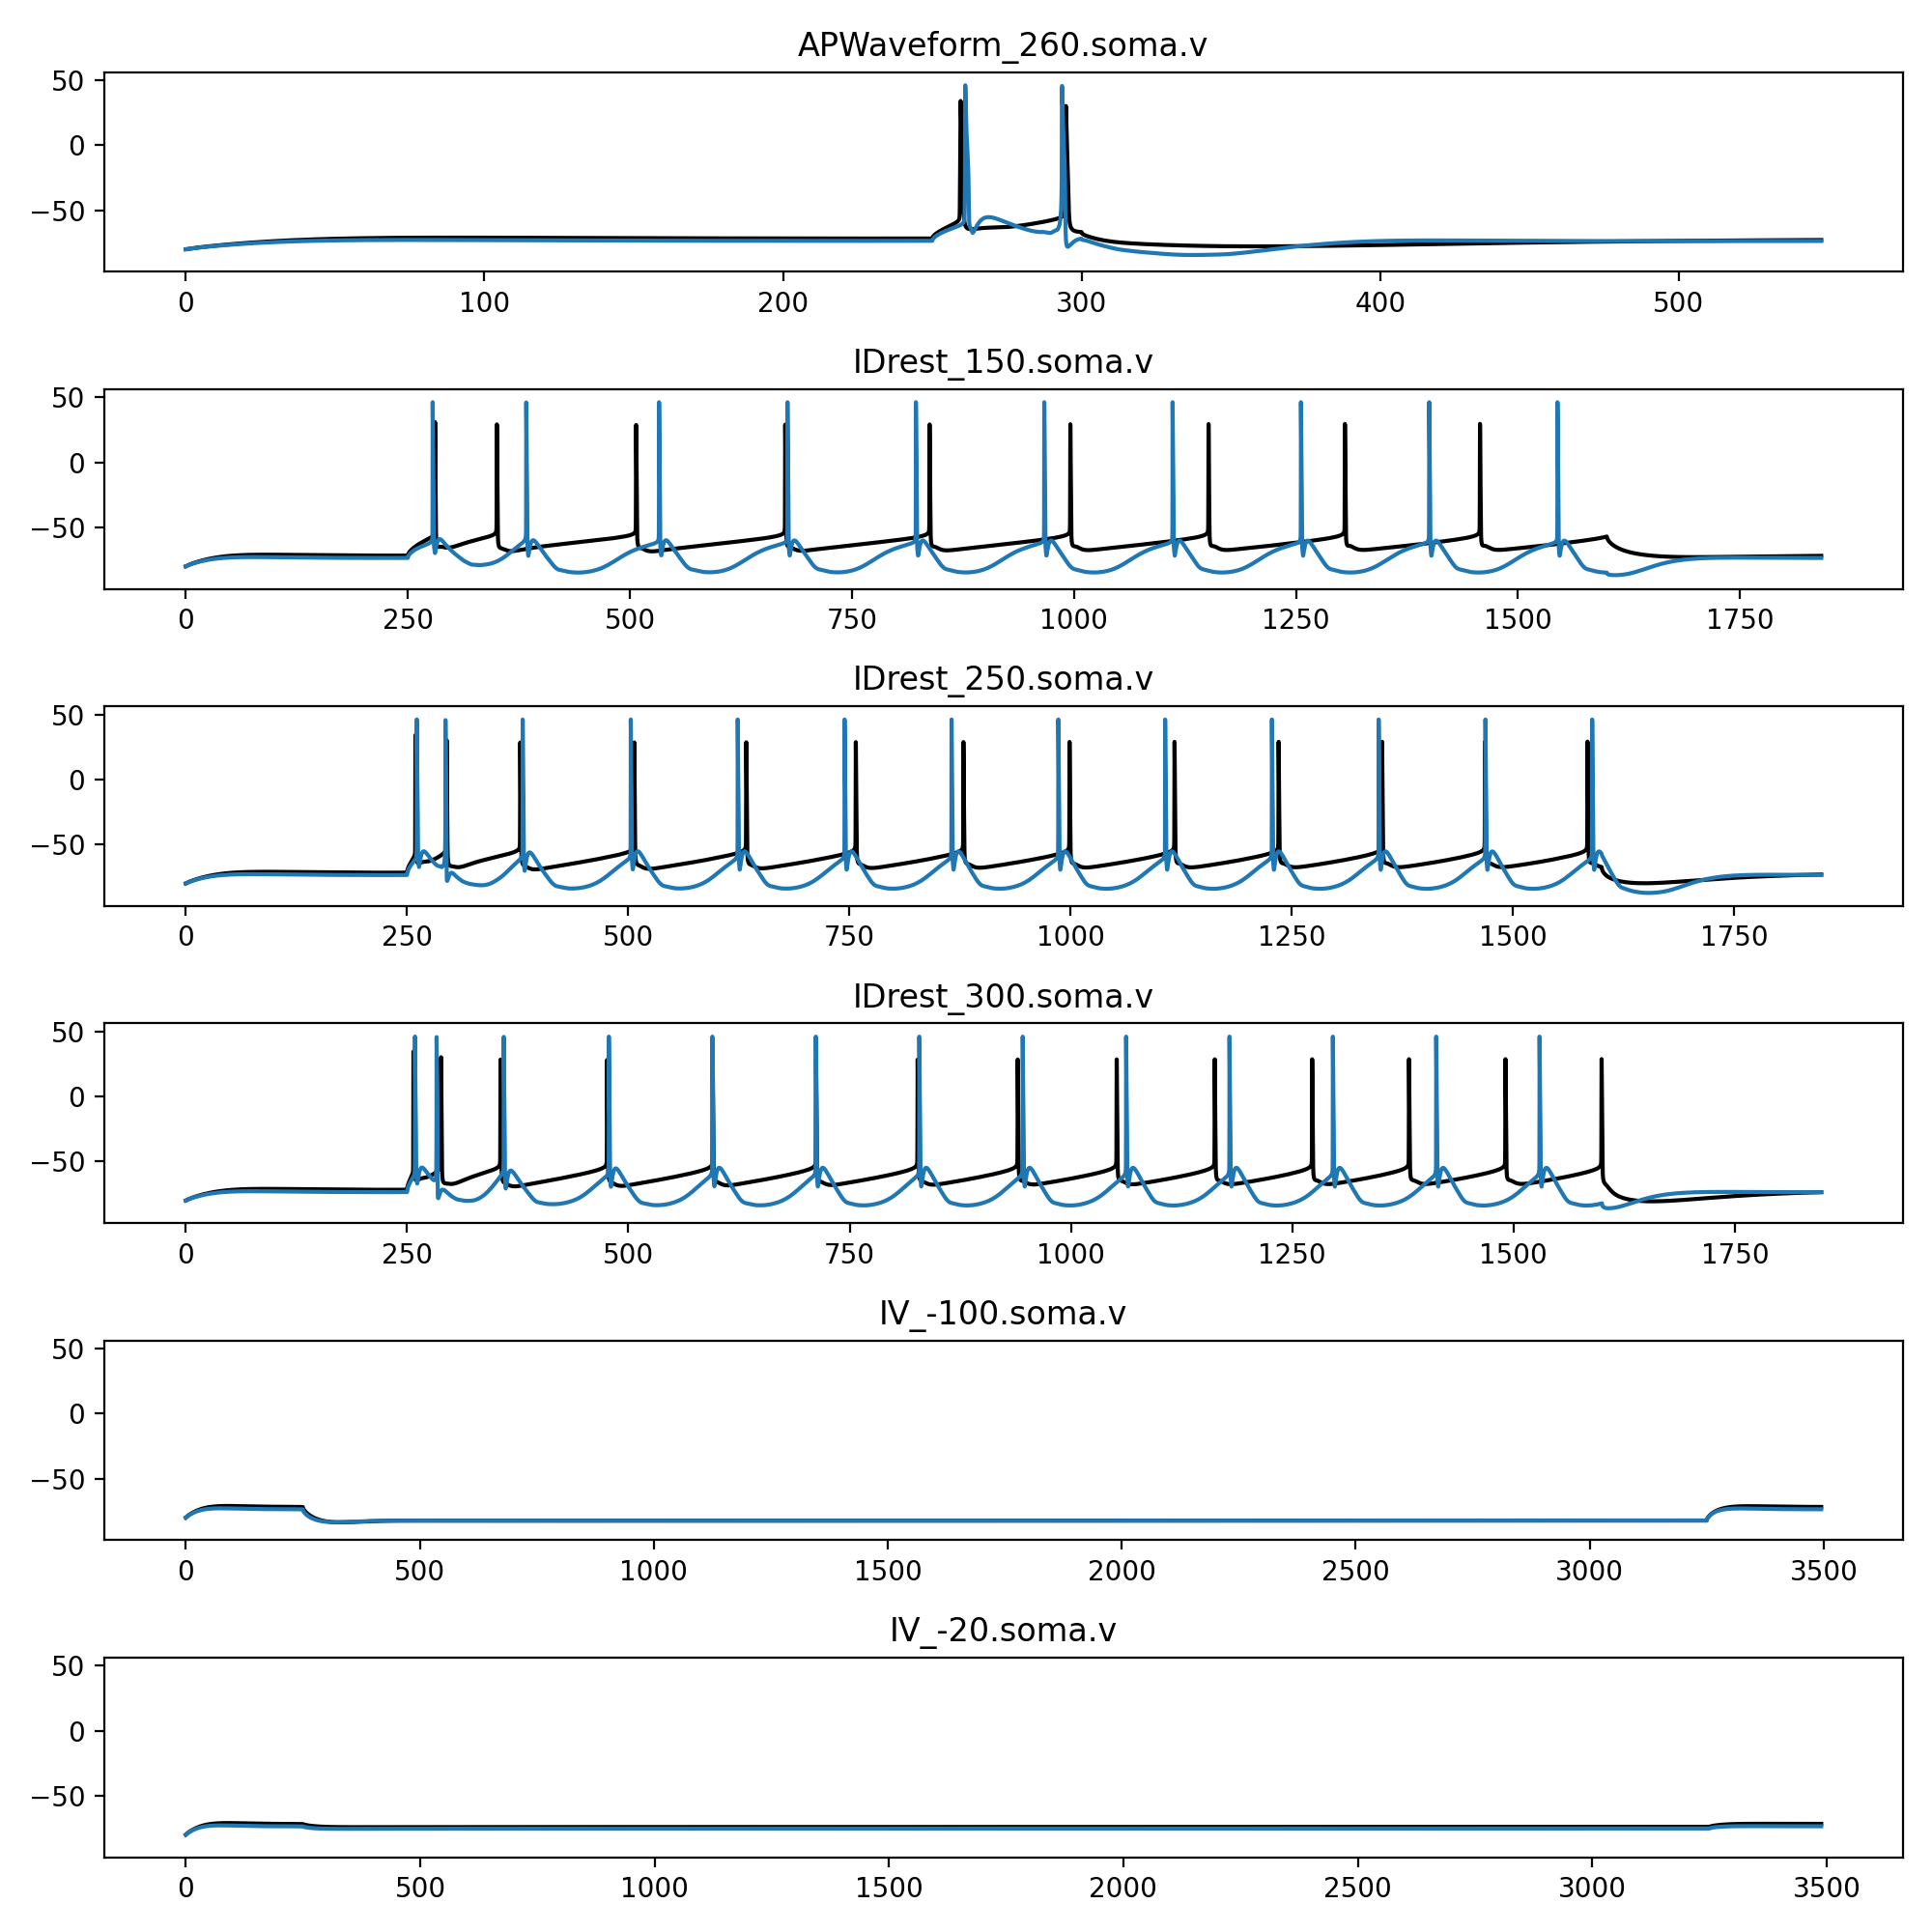

In [57]:
mf.plot_multiple_responses([responses_release, response_soma], colors=["k", "C0"])

<IPython.core.display.Javascript object>


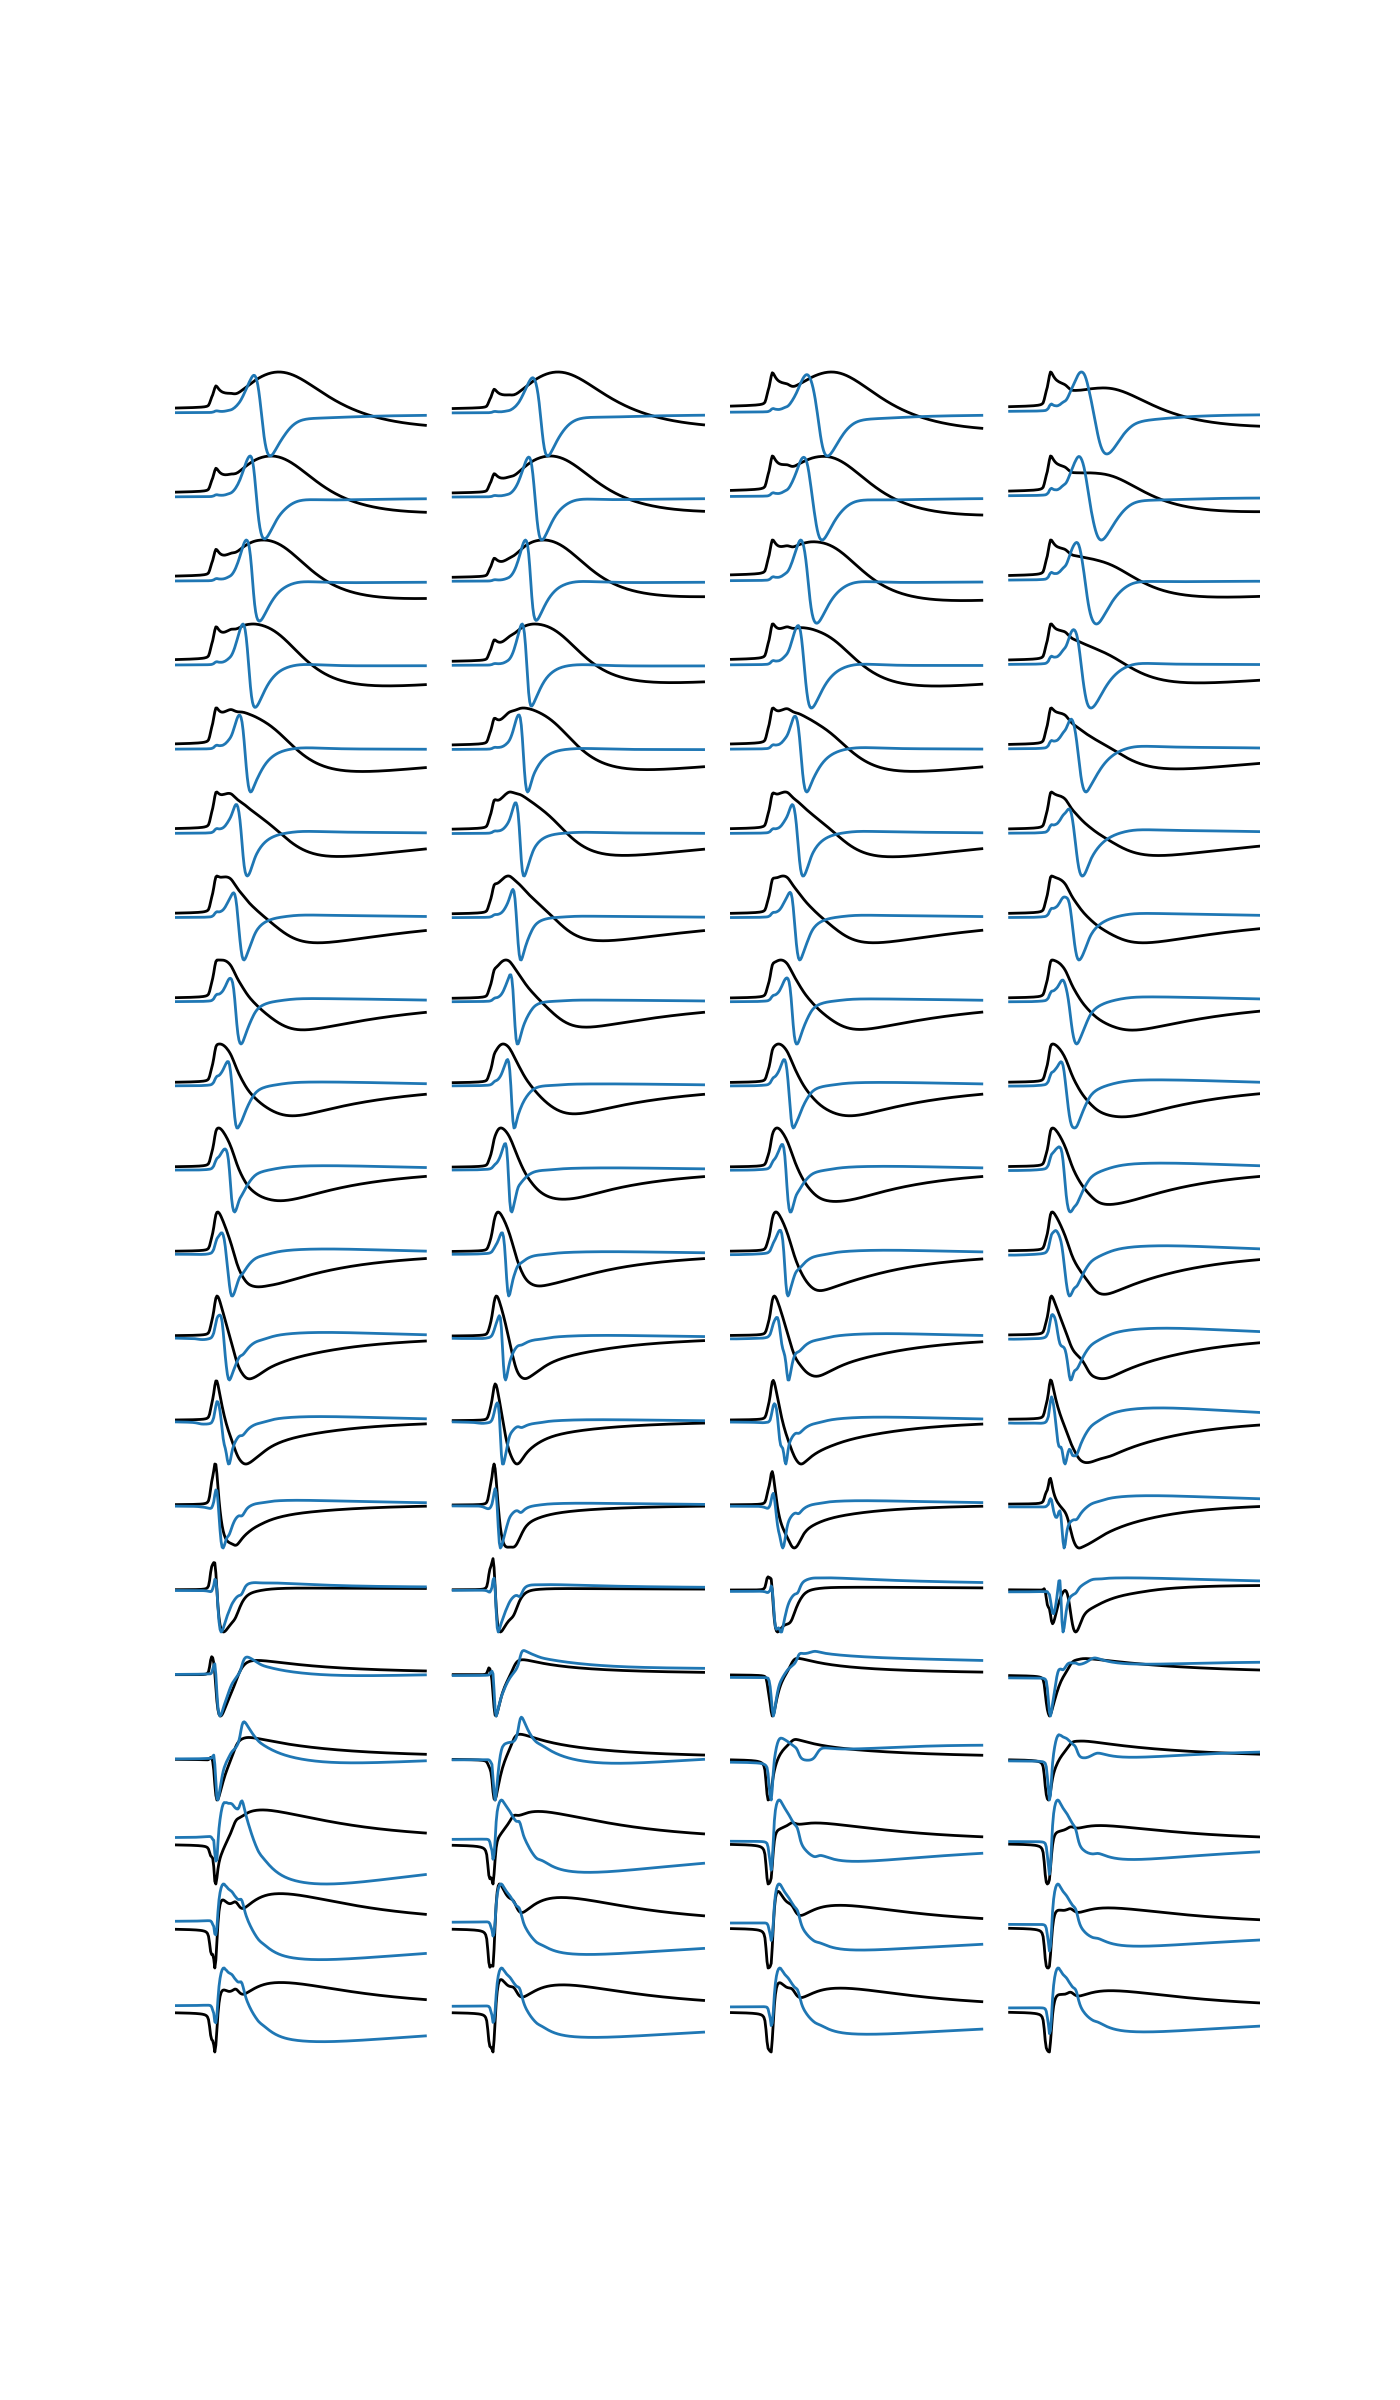

<AxesSubplot:>

In [58]:
mf.plot_multiple_eaps([responses_release, response_soma], eva_extra.fitness_protocols, probe,
                            protocol_name=protocol_for_eap, colors=["k", "C0"])

In [43]:
eap_dist_soma = distance.cosine(eap_release.ravel(), eap_soma.ravel())

## "extra" example

In [59]:
np.argmin(opt_extra.best_fitness)

2

In [60]:
params_sample_extra = opt_extra.iloc[2]
params_sample_extra_dict = {k: v for k, v in zip(param_names, params_sample_extra.best_params)}
display(params_sample_extra)

nevals            [20, 40, 60, 80, 100, 120, 140, 160, 180, 200,...
population        [[4.7567256949306e-05, 2.4158073779291668e-05,...
hof               ([4.7564805809113995e-05, 2.414005201705765e-0...
logbook           [{'gen': 1, 'nevals': 20, 'avg': 25694.9627776...
model                                                       hay_ais
seed                                                              7
extra_strategy                                                 None
feature_set                                                   extra
best_fitness                                             284.975465
best_scores       [5.4366835229918316, 0.0, 4.0295711481148615, ...
best_params       [4.7564805809113995e-05, 2.414005201705765e-05...
path              ../optimization_results/checkpoints/model=hay_...
Name: 10, dtype: object

In [61]:
response_extra = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), param_values=params_sample_extra_dict)

{}
{}
{}
{}
{}
{}


In [62]:
eap_extra = mf.utils.calculate_eap(responses=response_extra, protocols=eva_extra.fitness_protocols, 
                                   protocol_name=protocol_for_eap, **extra_kwargs)

<IPython.core.display.Javascript object>


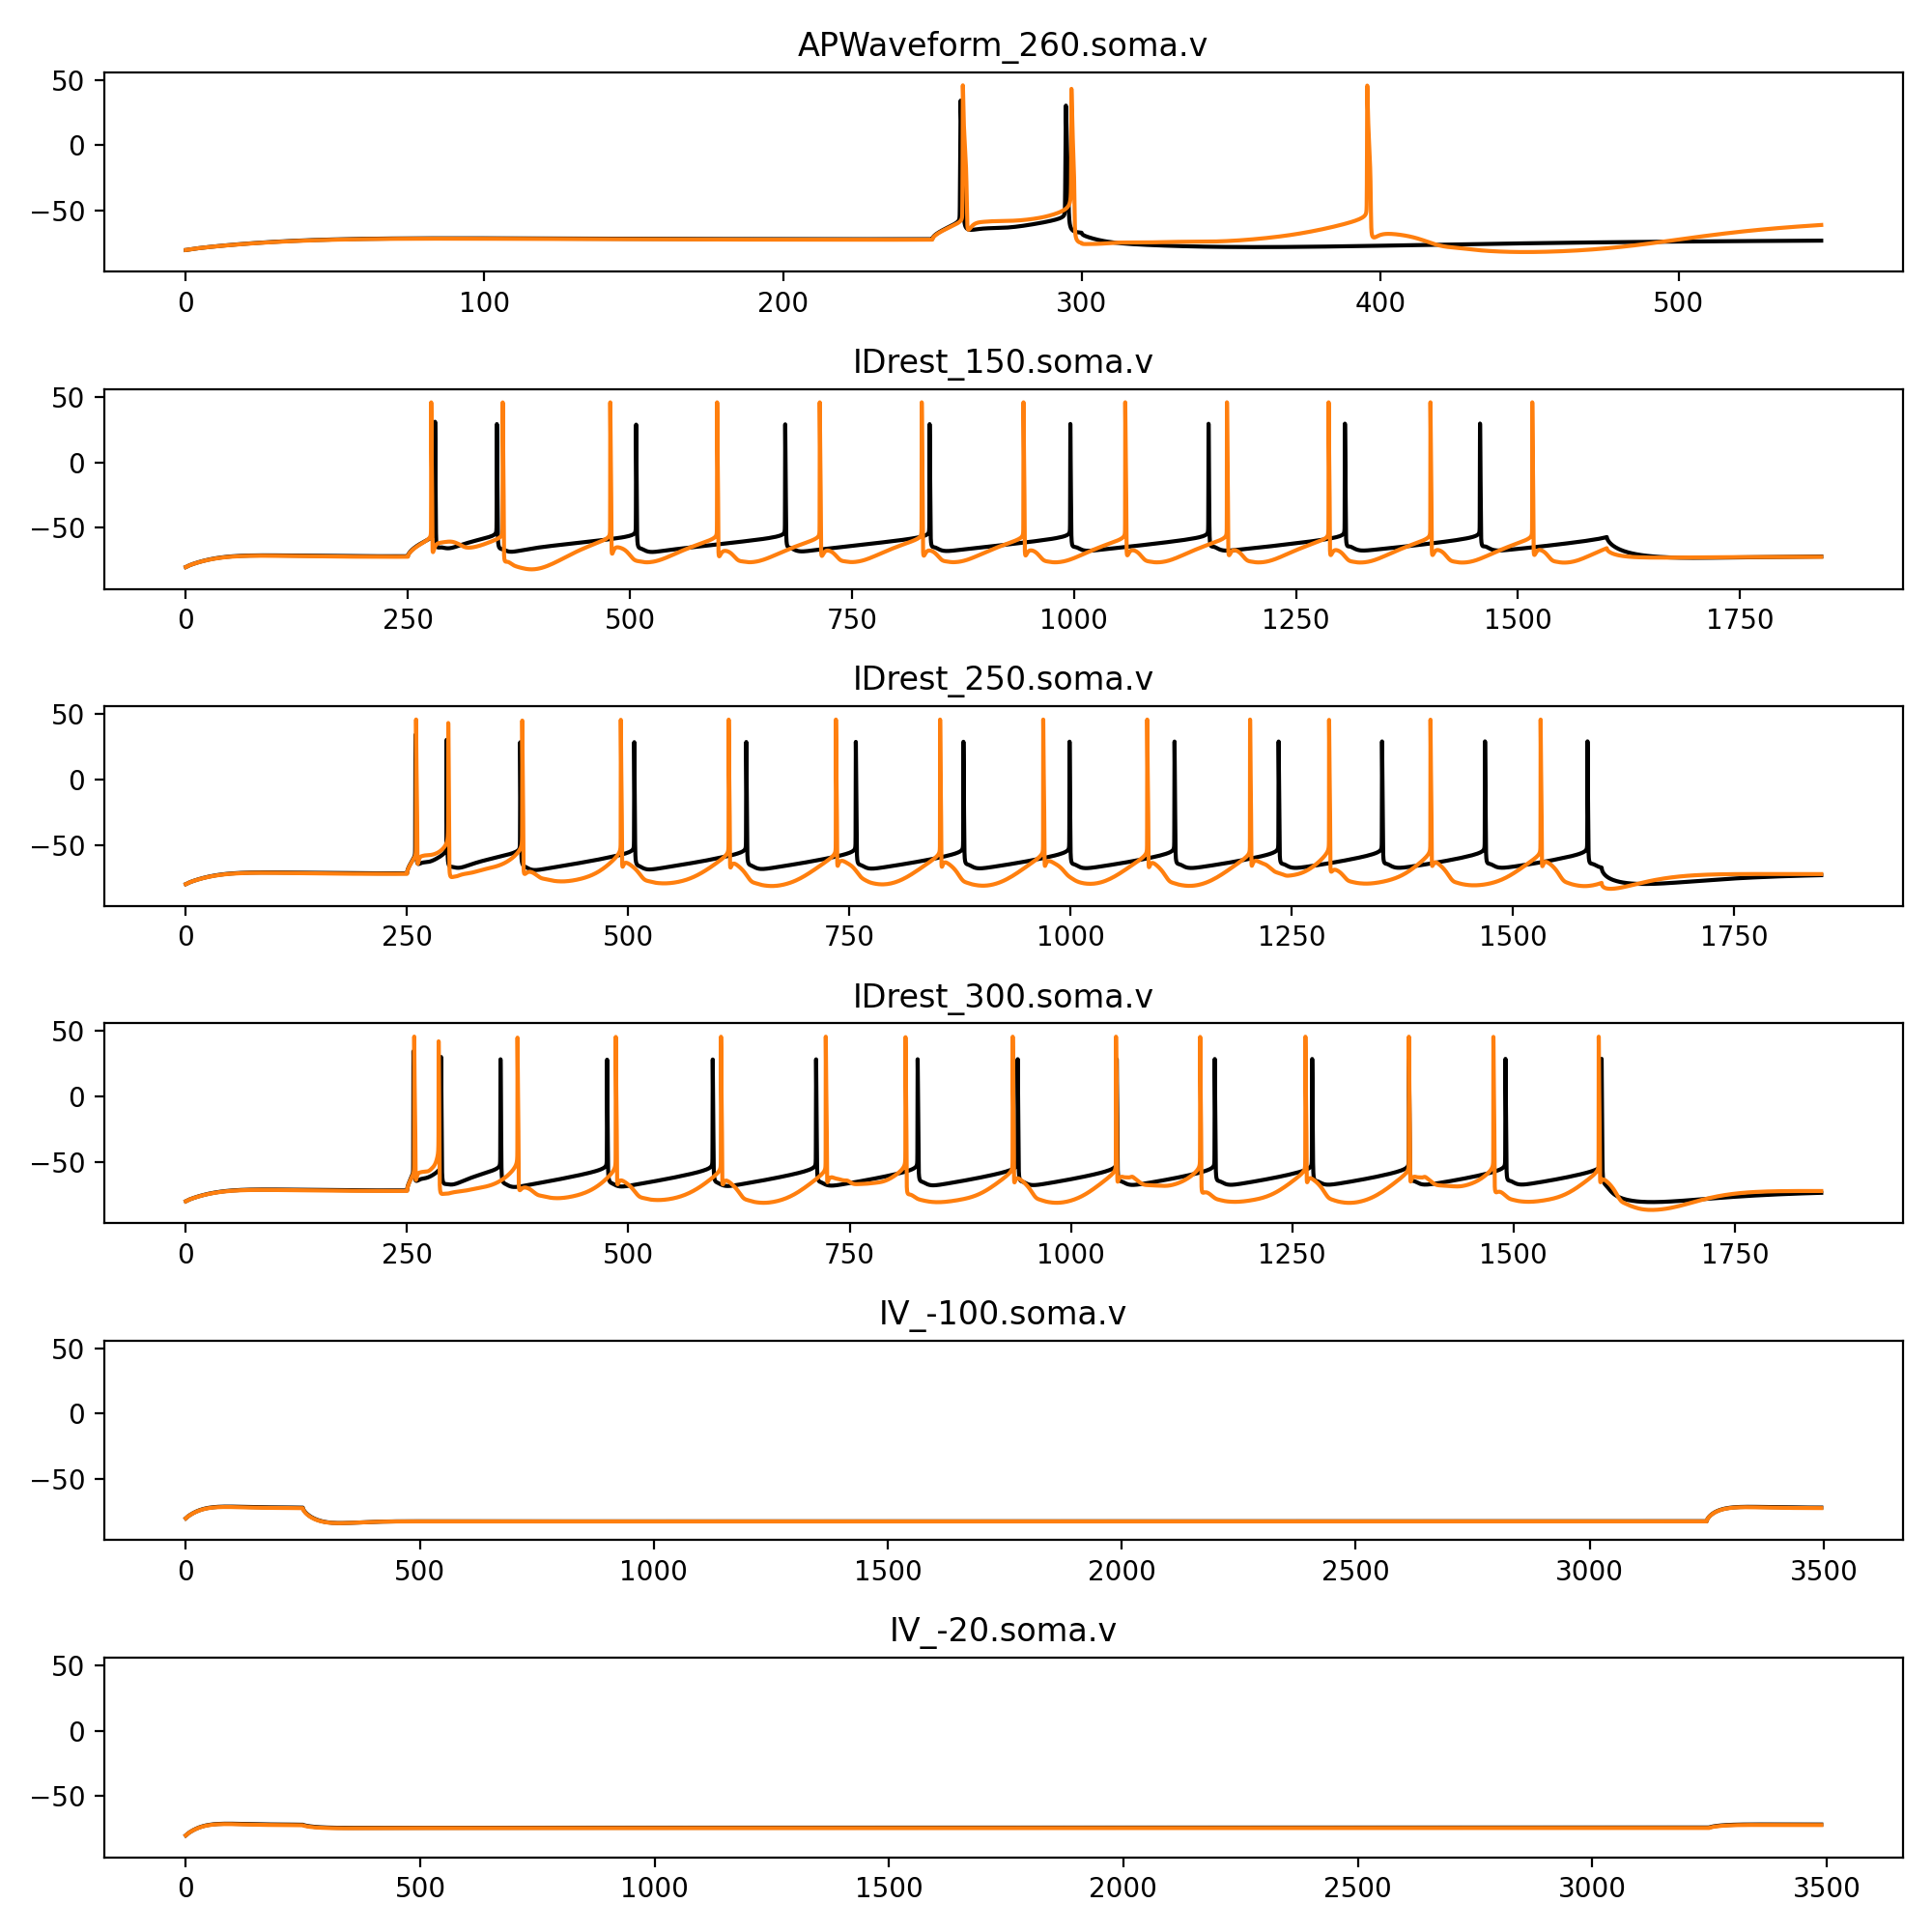

In [65]:
mf.plot_multiple_responses([responses_release, response_extra], colors=["k", "C1"])

<IPython.core.display.Javascript object>


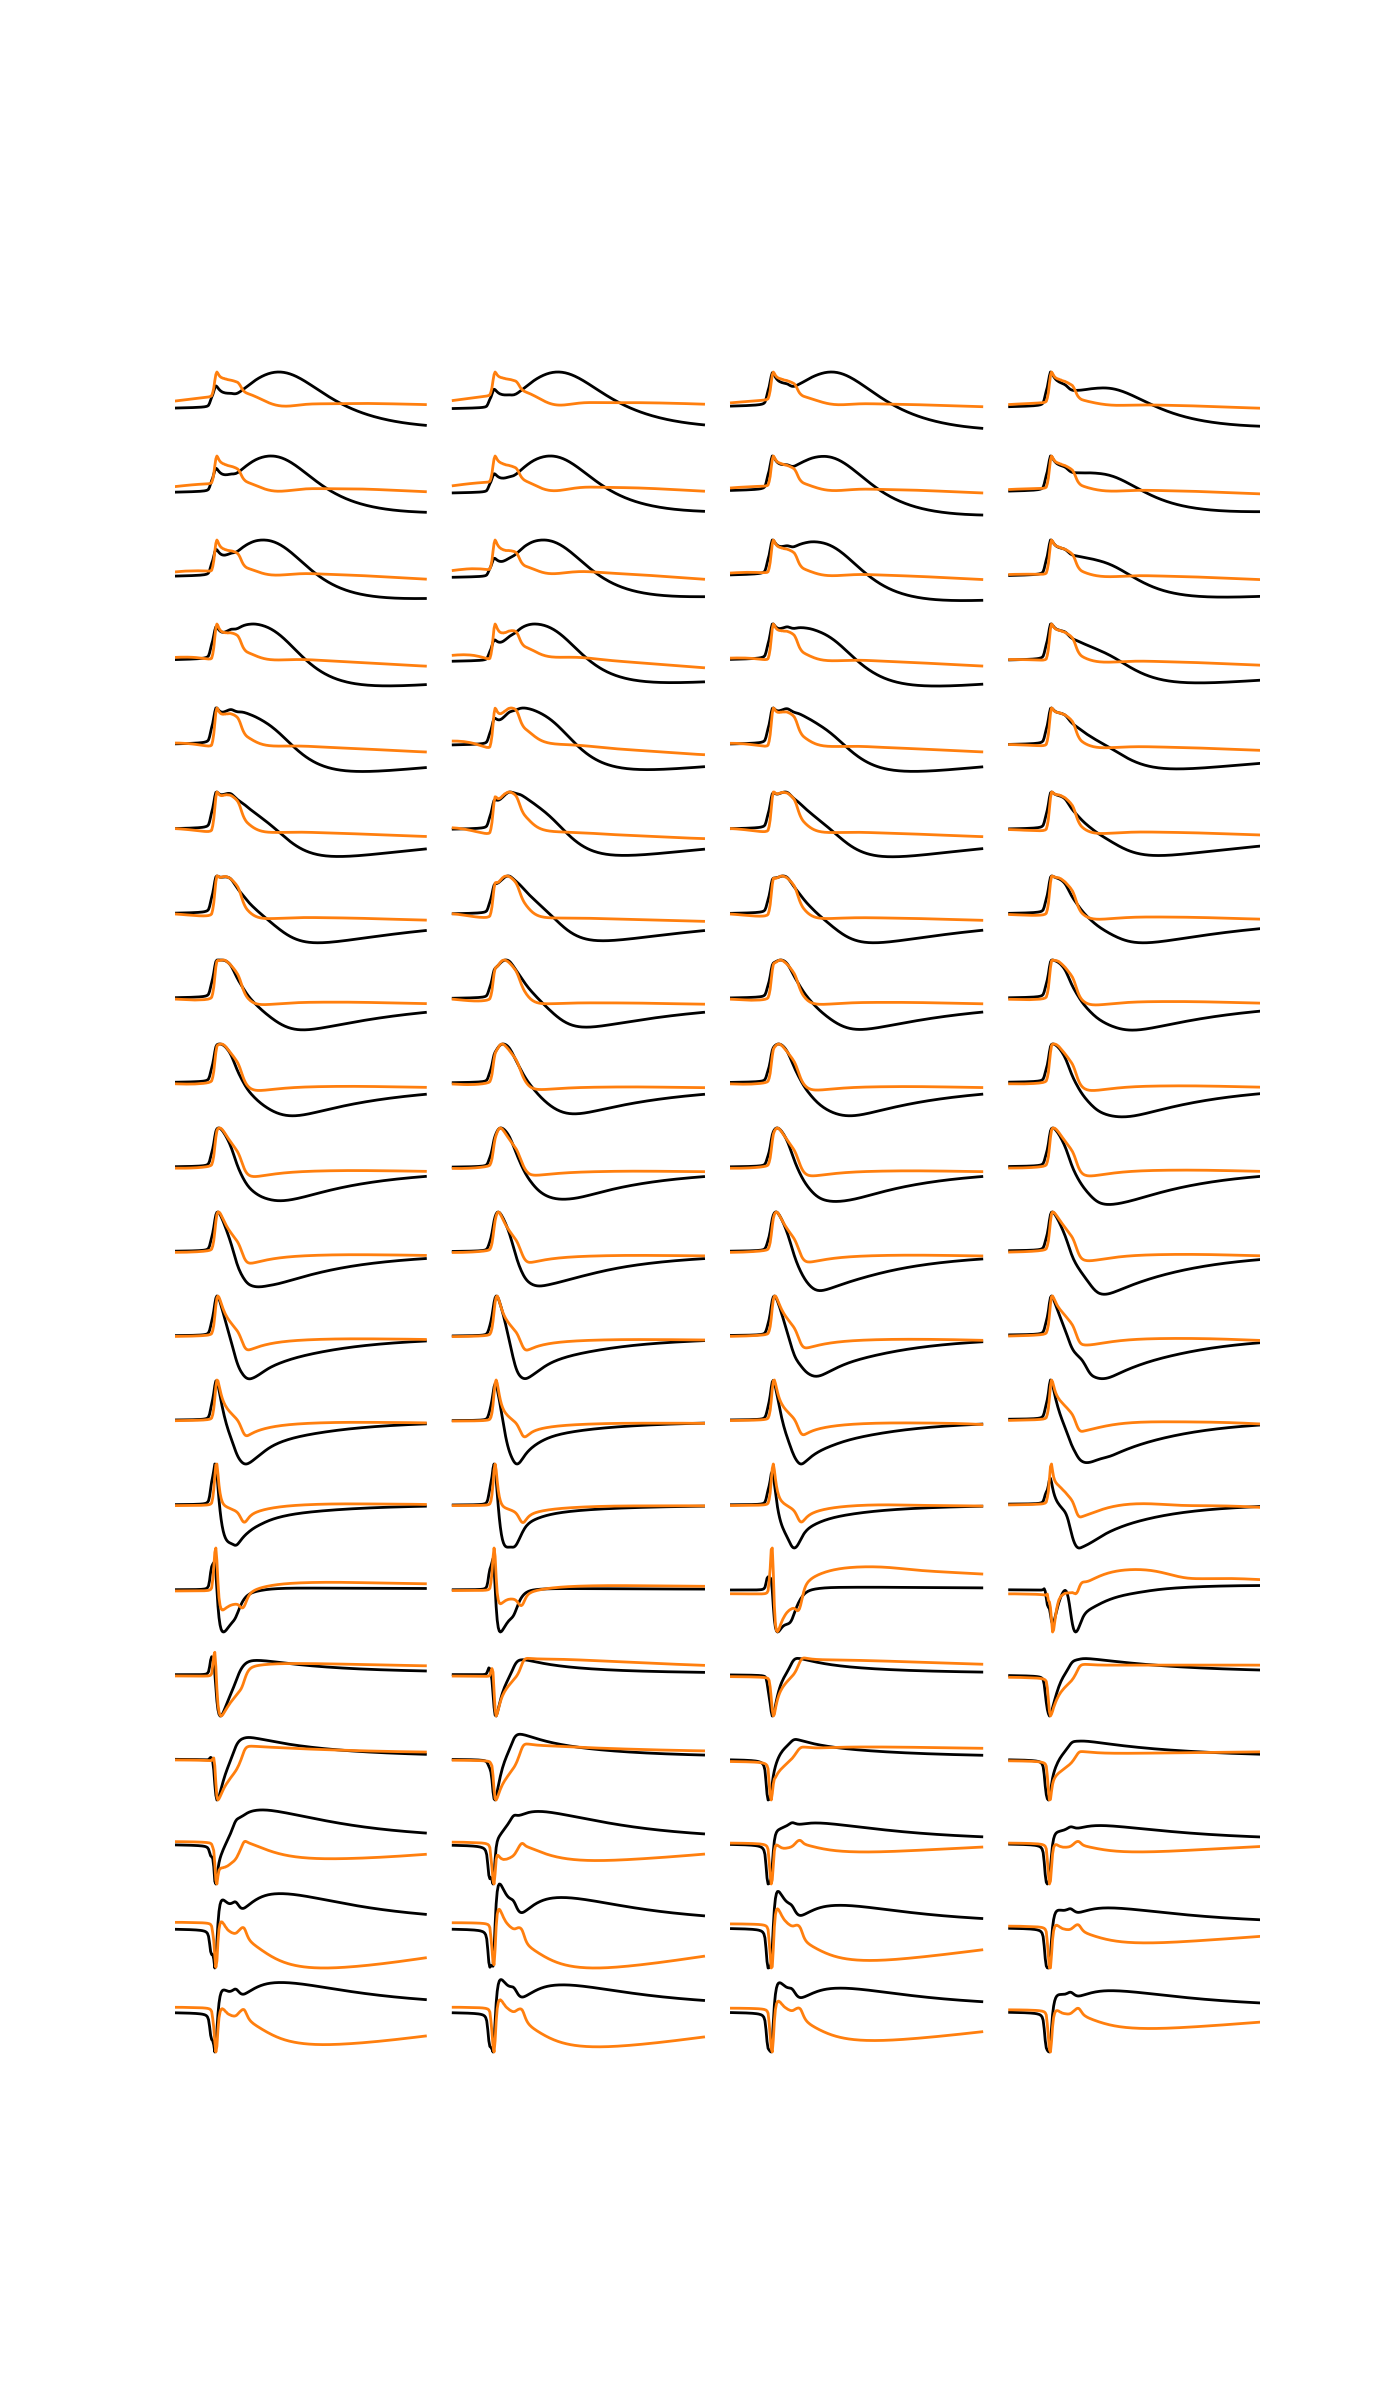

<AxesSubplot:>

In [66]:
mf.plot_multiple_eaps([responses_release, response_extra], eva_extra.fitness_protocols, probe,
                       protocol_name=protocol_for_eap, colors=["k", "C1"])

In [49]:
eap_dist_extra = distance.cosine(eap_release.ravel(), eap_extra.ravel())

In [50]:
print(eap_dist_soma, eap_dist_extra)

1.1115551055116395 1.0686052706003915


## Run protocols and compute features for all tested models

In [ ]:
feat_gt_dict = {}
for obj in eva_extra.fitness_calculator.objectives:
    feat_gt_dict[obj.features[0].name] = {}
    if len(obj.features) == 1:
        feat_value = obj.features[0].calculate_feature(responses_release)
        feat_score = obj.features[0].calculate_score(responses_release)
        feat_gt_dict[obj.features[0].name]["value"] = feat_value
        feat_gt_dict[obj.features[0].name]["score"] = feat_score
    else:
        print(f"More than one feature for objective: {obj.name}")

In [ ]:
feat_gt_dict["IDrest_300.soma.AP_amplitude"]

In [ ]:
opt_extra

In [ ]:
feats_soma = []
eaps_soma = []
params_soma = []
responses_soma = []

print("SOMA")
for i, (index, opt) in enumerate(opt_soma.iterrows()):
    print(f"Computing {i + 1} / {len(opt_soma)}")
    # get best params
    params_dict = {k: v for k, v in zip(param_names, opt.best_params)}
    params_soma.append(params_dict)
    
    # run protocols
    responses = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), 
                                        param_values=params_dict) 
    responses_soma.append(responses)
    try:
        eap = mf.utils.calculate_eap(responses=responses, protocols=eva_extra.fitness_protocols, 
                                     protocol_name=protocol_for_eap, **extra_kwargs)
    except:
        eap = np.zeros(eaps_soma[-1].shape)
    feat_dict = {}
    for obj in eva_extra.fitness_calculator.objectives:
        feat_dict[obj.features[0].name] = {}
        if len(obj.features) == 1:
            feat_value = obj.features[0].calculate_feature(responses)
            feat_score = obj.features[0].calculate_score(responses)
            feat_dict[obj.features[0].name]["value"] = feat_value
            feat_dict[obj.features[0].name]["score"] = feat_score
        else:
            print(f"More than one feature for objective: {obj.name}")
            
    feats_soma.append(feat_dict)
    eaps_soma.append(eap)
    
print("EXTRA")
feats_extra = []
eaps_extra = []
params_extra = []
responses_extra = []

for i, (index, opt) in enumerate(opt_extra.iterrows()):
    print(f"Computing {i + 1} / {len(opt_extra)}")
    # get best params
    params_dict = {k: v for k, v in zip(param_names, opt.best_params)}
    params_extra.append(params_dict)
    
    # run protocols
    responses = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), 
                                        param_values=params_dict)  
    responses_extra.append(responses)
    try:
        eap = mf.utils.calculate_eap(responses=responses, protocols=eva_extra.fitness_protocols, 
                                     protocol_name=protocol_for_eap, **extra_kwargs)
    except:
        eap = np.zeros(eaps_extra[-1].shape)
        
    feat_dict = {}
    for obj in eva_extra.fitness_calculator.objectives:
        feat_dict[obj.features[0].name] = {}
        if len(obj.features) == 1:
            feat_value = obj.features[0].calculate_feature(responses)
            feat_score = obj.features[0].calculate_score(responses)
            feat_dict[obj.features[0].name]["value"] = feat_value
            feat_dict[obj.features[0].name]["score"] = feat_score
        else:
            print(f"More than one feature for objective: {obj.name}")
            
    feats_extra.append(feat_dict)
    eaps_extra.append(eap)

## Compare parameters 

In [ ]:
param_json = model_folder / "parameters.json"

with param_json.open() as f:
    params = json.load(f)

param_boundaries = {}
for param in params:
    if "bounds" in param:
        param_boundaries[f"{param['param_name']}_{param['sectionlist']}"] = param["bounds"]

# scale params_release by boundaries
params_release_norm = {}
for param_name, param_val in params_release.items():
    bounds = param_boundaries[param_name]
    param_norm = (param_val - bounds[0]) / (bounds[1] - bounds[0])
    params_release_norm[param_name] = param_norm

In [ ]:
params_release_norm

In [ ]:
feature_set_array = []
seed_array = []
param_name_array = []
param_value_array = []
param_norm_array = []
release_value_array = []
release_norm_array = []
diff_with_release_array = []
section_array = []

for i, (index, opt) in enumerate(opt_soma.iterrows()):
    params_dict = {k: v for k, v in zip(param_names, opt.best_params)}
    
    for param_name, param_value in params_dict.items():
        feature_set_array.append(opt.feature_set)
        seed_array.append(opt.seed)   
        param_name_array.append(param_name)
        param_value_array.append(param_value)
        section_array.append(param_name.split("_")[-1])
        release_value_array.append(params_release[param_name])
        release_norm_array.append(params_release_norm[param_name])
        # compute norm value
        bounds = param_boundaries[param_name]
        param_norm = (param_value - bounds[0]) / (bounds[1] - bounds[0])
        param_norm_array.append(param_norm)
        diff_with_release_array.append(abs(param_norm - params_release_norm[param_name]))

for i, (index, opt) in enumerate(opt_extra.iterrows()):
    params_dict = {k: v for k, v in zip(param_names, opt.best_params)}
    
    for param_name, param_value in params_dict.items():
        feature_set_array.append(opt.feature_set)
        seed_array.append(opt.seed)   
        param_name_array.append(param_name)
        param_value_array.append(param_value)
        section_array.append(param_name.split("_")[-1])
        release_value_array.append(params_release[param_name])
        release_norm_array.append(params_release_norm[param_name])
        # compute norm value
        bounds = param_boundaries[param_name]
        param_norm = (param_value - bounds[0]) / (bounds[1] - bounds[0])
        param_norm_array.append(param_norm)
        diff_with_release_array.append(abs(param_norm - params_release_norm[param_name]))
        
df_params = pd.DataFrame({"seed": seed_array, "feature_set": feature_set_array, "param_name": param_name_array,
                          "param_value": param_value_array, "param_norm": param_norm_array, 
                          "release_value": release_value_array, "release_norm": release_norm_array,
                          "diff_release": diff_with_release_array, "section": section_array})

In [ ]:
df_params

In [ ]:
plt.figure()
sns.barplot(data=df_params, x="param_name", y="diff_release", hue="feature_set")
plt.xticks(rotation=45)

In [ ]:
fig, ax = plt.subplots()
sns.boxenplot(data=df_params.query("section in ['apical', 'somatic']"), 
              x="section", y="diff_release", hue="feature_set", ax=ax)
g = sns.swarmplot(data=df_params.query("section in ['apical', 'somatic']"), 
              x="section", y="diff_release", hue="feature_set", dodge=True,
              ax=ax)


In [ ]:
plt.figure()
sns.barplot(data=df_params.query("section in ['apical', 'somatic']"), 
            y="param_name", x="diff_release", hue="feature_set")
sns.despine(left=True, bottom=True)

## Compare features

In [ ]:
feature_set_array = []
seed_array = []
feature_name_array = []
feature_value_array = []
feature_score_array = []
feature_type_array = []

for i, feats in enumerate(feats_soma):
    for feat_name, feat_dict in feats.items():
        feature_set_array.append("soma")
        seed_array.append(i)
        feature_name_array.append(feat_name)
        if "MEA" not in feat_name:
            feature_type_array.append("soma")
            feature_value_array.append(feat_dict["value"])
        else:
            feature_type_array.append("MEA")
            feature_value_array.append(np.nan)
        feature_score_array.append(feat_dict["score"])
    
for i, feats in enumerate(feats_extra):
    for feat_name, feat_dict in feats.items():
        feature_set_array.append("extra")
        seed_array.append(i)
        feature_name_array.append(feat_name)
        if "MEA" not in feat_name:
            feature_type_array.append("soma")
            feature_value_array.append(feat_dict["value"])
        else:
            feature_type_array.append("MEA")
            feature_value_array.append(np.nan)
        feature_score_array.append(feat_dict["score"])
    
df_feats = pd.DataFrame({"seed": seed_array, "feature_set": feature_set_array, "feat_name": feature_name_array,
                         "feat_value": feature_value_array, "feat_score": feature_score_array,
                         "feat_type": feature_type_array})

In [ ]:
fig, ax = plt.subplots()

sns.boxenplot(data=df_feats.query("feat_type == 'soma'"), x="feature_set", y="feat_score", ax=ax)
g = sns.swarmplot(data=df_feats.query("feat_type == 'soma'"), x="feature_set", y="feat_score", ax=ax)
ax.set_ylabel("Feature scores (intracellular)", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Intracellular features", fontsize=15)

fig, ax = plt.subplots()

sns.boxenplot(data=df_feats.query("feat_type == 'MEA'"), x="feature_set", y="feat_score", ax=ax)
g = sns.swarmplot(data=df_feats.query("feat_type == 'MEA'"), x="feature_set", y="feat_score", ax=ax)
ax.set_ylabel("Feature scores (extracellular)", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Extracellular features", fontsize=15)


In [ ]:
plt.figure()
sns.barplot(data=df_feats.query("feat_type == 'MEA'"), 
            y="feat_name", x="feat_score", hue="feature_set")
sns.despine(left=True, bottom=True)

In [ ]:
plt.figure()
sns.barplot(data=df_feats.query("feat_type == 'soma'"), 
            y="feat_name", x="feat_score", hue="feature_set")
sns.despine(left=True, bottom=True)

## Compare EAP distance

In [ ]:
feature_set_array = []
seed_array = []
eap_dist_array = []

for i, eap in enumerate(eaps_soma):
    feature_set_array.append("soma")
    seed_array.append(i)
    eap_dist_array.append(distance.cosine(eap_release.ravel(), eap.ravel()))
    
for i, eap in enumerate(eaps_extra):
    feature_set_array.append("extra")
    seed_array.append(i)
    eap_dist_array.append(distance.cosine(eap_release.ravel(), eap.ravel()))

    
df_eap = pd.DataFrame({"seed": seed_array, "feature_set": feature_set_array, "eap_dist": eap_dist_array})

In [ ]:
fig, ax = plt.subplots()
sns.barplot(data=df_eap, x="feature_set", y="eap_dist", ax=ax)
sns.swarmplot(data=df_eap, x="feature_set", y="eap_dist", dodge=True, ax=ax, palette=["cornflowerblue", "orange"])
ax.set_ylabel("Cosine distance", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Extracellular difference", fontsize=15)

## Plot responses

In [ ]:
mf.plot_multiple_eaps(responses_soma + [responses_release], eva_extra.fitness_protocols, probe,
                      protocol_name=protocol_for_eap, colors=["C0"] * len(responses_soma) + ["k"])
mf.plot_multiple_eaps(responses_soma + [responses_release], eva_extra.fitness_protocols, probe,
                      protocol_name=protocol_for_eap, colors=["C0"] * len(responses_soma) + ["k"], 
                      norm=False)

In [ ]:
mf.plot_multiple_eaps(responses_extra + [responses_release], eva_extra.fitness_protocols, probe,
                      protocol_name=protocol_for_eap, colors=["C1"] * len(responses_extra) + ["k"])
mf.plot_multiple_eaps(responses_extra + [responses_release], eva_extra.fitness_protocols, probe,
                      protocol_name=protocol_for_eap, colors=["C1"] * len(responses_extra) + ["k"], 
                      norm=False)

In [ ]:
fig_soma = mf.plot_multiple_responses(responses_list=responses_soma + [responses_release], 
                                      max_rows=3, colors=["C0"] * len(responses_soma) + ['k'], 
                                      return_fig=True)

In [ ]:
fig_extra = mf.plot_multiple_responses(responses_list=responses_extra + [responses_release], 
                                      max_rows=3, colors=["C1"] * len(responses_extra) + ['k'], 
                                      return_fig=True)